In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk 
import re

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud, STOPWORDS
from subprocess import check_output

%matplotlib inline

In [2]:
df_train=pd.read_csv('train_author.csv')
df_test=pd.read_csv('test_author.csv')

# Exploratory Analysis of Data

In [3]:
df_train.shape

(19579, 3)

In [4]:
df_train.columns

Index(['id', 'text', 'author'], dtype='object')

In [5]:
df_train.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id24045,"It was, he said, a constitutional and a family...",EAP
freq,1,1,7900


In [6]:
df_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


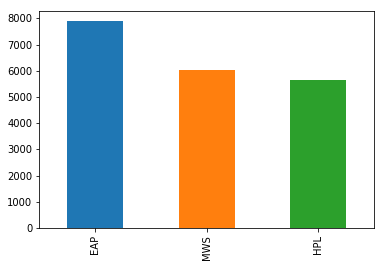

In [7]:
df_train.author.value_counts().plot(kind='bar')

In [8]:
df_test.shape

(8392, 2)

In [9]:
df_test.columns

Index(['id', 'text'], dtype='object')

In [10]:
df_test.describe()

,id,text
count,8392,8392
unique,8392,8392
top,id03184,"I do not hesitate to say that I am amazed, and..."
freq,1,1


In [17]:
def wordcloud_draw(data, color='black'):
    words=' '.join(data)
    cleaned_word=' '.join([word for word in words.split()])
    wordcloud=WordCloud(stopwords=STOPWORDS, \
                        background_color=color,\
                        width=2500,
                        height=2000
                       ).generate(cleaned_word)
    plt.figure(1, figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

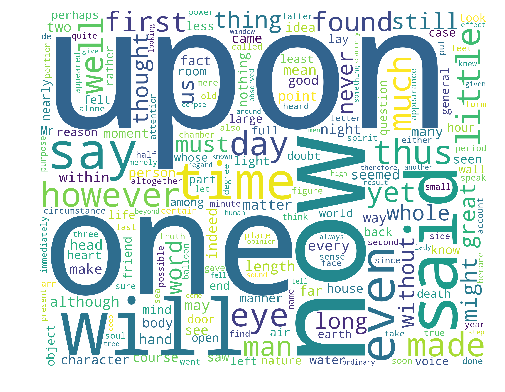

In [18]:
eap=df_train[df_train.author=='EAP'].text
wordcloud_draw(eap, color='white')

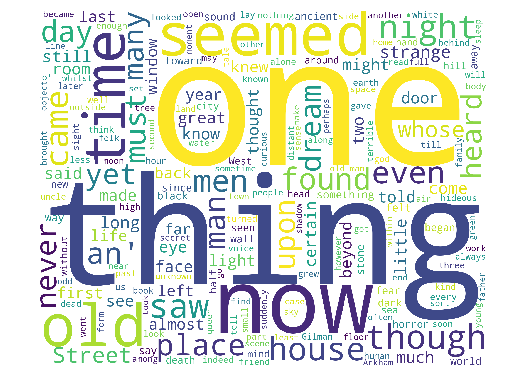

In [19]:
hpl=df_train[df_train.author=='HPL'].text
wordcloud_draw(hpl, color='white')

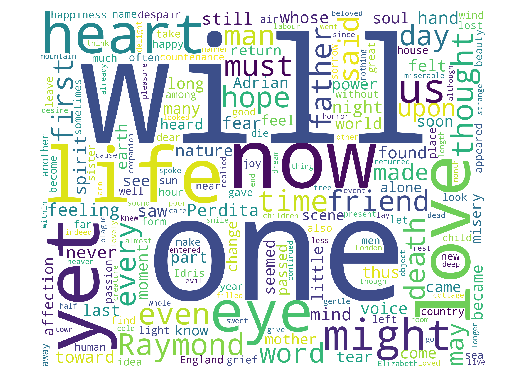

In [20]:
mws=df_train[df_train.author=='MWS'].text
wordcloud_draw(mws, color='white')

# Clean Text Data

In [21]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus=[]
corpust=[]

In [22]:
for i in range(0,df_train.shape[0]):
    text=re.sub('[^a-zA-Z]', ' ', df_train.text[i])
    text=text.lower()
    text=text.split()
    ps=PorterStemmer()
    text=[ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text=' '.join(text)
    corpus.append(text)

for i in range(0,df_test.shape[0]):
    textt=re.sub('[^a-zA-Z]', ' ', df_test.text[i])
    textt=textt.lower()
    textt=textt.split()
    ps=PorterStemmer()
    textt=[ps.stem(word) for word in textt if not word in set(stopwords.words('english'))]
    textt=' '.join(textt)
    corpust.append(textt)

In [23]:
# Encode categorical dependent variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
y = df_train.iloc[:, 2].values
labelencoder_y = LabelEncoder()
Y = labelencoder_y.fit_transform(y)

In [24]:
# Create a Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=11000)
Xtrain = cv.fit_transform(corpus).toarray()
Xtest=cv.fit_transform(corpust).toarray()

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv=TfidfVectorizer(max_features=11000)
Xtraint=tv.fit_transform(corpus).toarray()
Xtestt=cv.fit_transform(corpust).toarray()

# Build and Test the Model within the Training Data

In [26]:
# Split the training dataset 
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain, Y, test_size = 0.25, random_state = 0)
X_traint, X_testt, y_traint, y_testt = train_test_split(Xtraint, Y, test_size = 0.25, random_state = 0)

C:\Users\pengq\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
X_traint

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# Fit the data in logisticRegression Model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
classifier_log = LogisticRegression()
classifier_log.fit(X_train, y_train)
pred=classifier_log.predict(X_test)
score=metrics.accuracy_score(y_test, pred)
score

0.8118488253319714

# Predict the Test Data

In [31]:
# Predict the test data
y_pred_log_test = classifier_log.predict(Xtest)

In [32]:
# Get the predict_probability for each id
predict_prob_test=classifier_log.predict_proba(Xtest)

# Final Submission

In [33]:
submission=pd.DataFrame({'id':df_test.id,\
                              'text': df_test.text,\
                              'prediction': y_pred_log_test,\
                              'predic_prob_EAP': predict_prob_test[:,0],
                              'predic_prob_HPL': predict_prob_test[:,1],
                              'predic_prob_MWS': predict_prob_test[:,2]})

In [34]:
submission.loc[submission.prediction==0, 'prediction']='EAP'
submission.loc[submission.prediction==1, 'prediction']='HPL'
submission.loc[submission.prediction==2, 'prediction']='MWS'

In [35]:
submission

,id,predic_prob_EAP,predic_prob_HPL,predic_prob_MWS,prediction,text
0,id02310,0.787514,0.111646,0.100841,EAP,"Still, as I urged our leaving Ireland with suc..."
1,id24541,0.423710,0.573728,0.002562,HPL,"If a fire wanted fanning, it could readily be ..."
2,id00134,0.138006,0.774319,0.087675,HPL,And when they had broken down the frail door t...
3,id27757,0.102341,0.851167,0.046492,HPL,While I was thinking how I should possibly man...
4,id04081,0.706470,0.181850,0.111680,EAP,I am not sure to what limit his knowledge may ...
5,id27337,0.899565,0.007775,0.092660,EAP,"""The thick and peculiar mist, or smoke, which ..."
6,id24265,0.415794,0.342373,0.241833,EAP,"That which is not matter, is not at all unless..."
7,id25917,0.802175,0.159196,0.038630,EAP,I sought for repose although I did not hope fo...
8,id04951,0.327171,0.017702,0.655127,MWS,"Upon the fourth day of the assassination, a pa..."
9,id14549,0.538492,0.021818,0.439690,EAP,"""The tone metaphysical is also a good one."


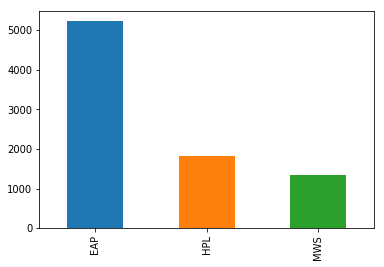

In [36]:
submission.prediction.value_counts().plot(kind='bar')